In [112]:
# ライブラリの取得
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(font="IPAexGothic",style="white")　多分いらなそう
# import oandapy
import configparser
import datetime
from datetime import datetime, timedelta

import warnings
warnings.simplefilter('ignore')

# CSVデータの読み込み
import os
working_directory=os.getcwd()
#print(working_directory)
path_train=working_directory+'/train_finance.csv'
path_test=working_directory+'/test_finance.csv'
# path_test=working_directory+'/test_finance_last10elminate.csv'
path_latest=working_directory+'/test_latest.csv'
path_submit=working_directory+'/submit_finance.csv'

#データフレームの生成
df_train=pd.read_csv(path_train)
df_test=pd.read_csv(path_test)
df_latest=pd.read_csv(path_latest)
df_submit=pd.read_csv(path_submit)

In [113]:
# Dateがobject型になっているので日付型に変換
df_train['Date']=pd.to_datetime(df_train['Date'],format='%Y/%m/%d')
df_test['Date']=pd.to_datetime(df_test['Date'],format='%Y/%m/%d')
df_latest['Date']=pd.to_datetime(df_latest['Date'],format='%Y/%m/%d')

In [114]:
# Dateが日付型に変更されたかどうかの確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074 entries, 0 to 2073
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2074 non-null   datetime64[ns]
 1   High    2074 non-null   float64       
 2   Low     2074 non-null   float64       
 3   Open    2074 non-null   float64       
 4   Close   2074 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 81.1 KB


In [115]:
# Dateが日付型に変更されたかどうかの確認
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1246 non-null   datetime64[ns]
 1   High    1246 non-null   float64       
 2   Low     1246 non-null   float64       
 3   Open    1246 non-null   float64       
 4   Close   1246 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 48.8 KB


In [116]:
#データの確認
df_train.describe()

,High,Low,Open,Close
count,2074.000000,2074.000000,2074.000000,2074.000000
mean,124.078238,122.910559,123.526205,123.529490
std,9.210193,9.493319,9.188003,9.184970
min,108.520946,6.743457,107.993884,107.998923
25%,117.002707,115.863246,116.408944,116.427990
50%,123.242134,121.951219,122.590435,122.573382
75%,130.814157,129.393252,130.201913,130.179930
max,148.260942,146.834717,147.832063,147.888796


### Train異常値処理

In [117]:
# Trainデータ異常値
df_train[(df_train['Low']<10)]
no=df_train[(df_train['Low']<10)].index
# print(f'欠損データ確認(df_train)\n{typeInfo(no)}\n')

In [118]:
# df_train.iloc[no:no+1] #インデックス指定されてるものでないとilocの範囲指定に使えない
print(f'異常値▲1日\n{df_train.iloc[no-1]}\n')
print(f'異常値当日\n{df_train.iloc[no]}\n')
print(f'異常値+1日\n{df_train.iloc[no+1]}\n')

異常値▲1日
           Date        High         Low        Open       Close
1114 2008-03-14  145.059359  143.736202  144.513188  144.465784

異常値当日
           Date        High       Low        Open       Close
1115 2008-03-17  147.103265  6.743457  145.669288  145.669288

異常値+1日
           Date        High         Low        Open      Close
1116 2008-03-18  146.409411  144.456764  145.660125  144.83676



In [119]:
# 様々な記法一覧
print(f'1\n{df_train.iloc[no,2]}\n')
print(f'1\n{df_train.iloc[1115].Low}\n')
# print(f'1\n{df_train.at[df_train.index[1115],'Low']}\n')

1
1115    6.743457
Name: Low, dtype: float64

1
6.743457186967135



In [120]:
ave =(df_train['Low'][1114]+df_train['Low'][1116]) /2
ave

144.09648299217224

In [121]:
df_train['Low'][1115]=ave
df_train['Low'][1115]

144.09648299217224

In [122]:
df_train.describe()

,High,Low,Open,Close
count,2074.000000,2074.000000,2074.000000,2074.000000
mean,124.078238,122.976785,123.526205,123.529490
std,9.210193,9.155624,9.188003,9.184970
min,108.520946,107.748581,107.993884,107.998923
25%,117.002707,115.876669,116.408944,116.427990
50%,123.242134,121.954434,122.590435,122.573382
75%,130.814157,129.426294,130.201913,130.179930
max,148.260942,146.834717,147.832063,147.888796


In [123]:
#データの確認
df_test.describe()

,High,Low,Open,Close
count,1246.000000,1246.000000,1246.000000,1246.000000
mean,111.424603,110.675657,111.069958,111.070373
std,9.206534,9.270658,9.215541,9.214999
min,96.767439,70.352906,96.364197,96.357173
25%,103.722807,103.064503,103.422443,103.422154
50%,108.456692,107.796669,108.091687,108.082215
75%,120.690221,119.751722,120.218867,120.219641
max,129.417693,128.691531,128.851618,128.858797


## 単純移動平均の追加

In [124]:
#　移動平均の期間
span01=6
span02=6
span03=12

In [125]:
df_train['SMA01']=df_train['Close'].rolling(window=span01).mean()
df_test['SMA01']=df_test['Close'].rolling(window=span01).mean()

# df_train['SMA02']=df_train['Close'].rolling(window=span01).mean()
# df_test['SMA02']=df_test['Close'].rolling(window=span01).mean()

# df_train['SMA03']=df_train['Close'].rolling(window=span01).mean()
# df_test['SMA03']=df_test['Close'].rolling(window=span01).mean()

In [126]:
# 
print(f'train\n{df_train}\n')
print(f'test\n{df_test}\n')

train
           Date        High         Low        Open       Close       SMA01
0    2003-12-01  111.370639  110.482062  111.314347  110.676377         NaN
1    2003-12-02  112.008532  110.500532  110.639316  111.823016         NaN
2    2003-12-03  112.202814  111.712284  111.832477  112.137524         NaN
3    2003-12-04  112.332259  111.406851  112.110343  111.748717         NaN
4    2003-12-05  112.766375  111.609834  111.721723  112.729259         NaN
...         ...         ...         ...         ...         ...         ...
2069 2011-12-08  124.476855  123.126484  123.959751  123.984661  124.154053
2070 2011-12-09  124.227770  122.895824  123.445260  123.445260  124.002202
2071 2011-12-12  123.745819  122.202555  123.681290  123.687906  123.855345
2072 2011-12-13  122.393352  121.174807  121.782641  121.832361  123.473057
2073 2011-12-14  120.796608  119.824855  120.508620  120.427021  122.906395

[2074 rows x 6 columns]

test
           Date        High         Low        Open

In [127]:
# 移動平均1日目を取り合えす終値で埋める
df_train['SMA01'][0]=df_train['Close'][0]
df_test['SMA01'][0]=df_test['Close'][0]

# df_train['SMA02'][0]=df_train['Close'][0]
# df_test['SMA02'][0]=df_test['Close'][0]

# df_train['SMA03'][0]=df_train['Close'][0]
# df_test['SMA03'][0]=df_test['Close'][0]

In [128]:
# 結果
print(f'train\n{df_train}\n')
print(f'test\n{df_test}\n')

train
           Date        High         Low        Open       Close       SMA01
0    2003-12-01  111.370639  110.482062  111.314347  110.676377  110.676377
1    2003-12-02  112.008532  110.500532  110.639316  111.823016         NaN
2    2003-12-03  112.202814  111.712284  111.832477  112.137524         NaN
3    2003-12-04  112.332259  111.406851  112.110343  111.748717         NaN
4    2003-12-05  112.766375  111.609834  111.721723  112.729259         NaN
...         ...         ...         ...         ...         ...         ...
2069 2011-12-08  124.476855  123.126484  123.959751  123.984661  124.154053
2070 2011-12-09  124.227770  122.895824  123.445260  123.445260  124.002202
2071 2011-12-12  123.745819  122.202555  123.681290  123.687906  123.855345
2072 2011-12-13  122.393352  121.174807  121.782641  121.832361  123.473057
2073 2011-12-14  120.796608  119.824855  120.508620  120.427021  122.906395

[2074 rows x 6 columns]

test
           Date        High         Low        Open

In [129]:
#線形補間
df_train=df_train.interpolate()
df_test=df_test.interpolate()

In [130]:
# 結果
print(f'train\n{df_train}\n')
print(f'test\n{df_test}\n')

train
           Date        High         Low        Open       Close       SMA01
0    2003-12-01  111.370639  110.482062  111.314347  110.676377  110.676377
1    2003-12-02  112.008532  110.500532  110.639316  111.823016  110.946101
2    2003-12-03  112.202814  111.712284  111.832477  112.137524  111.215825
3    2003-12-04  112.332259  111.406851  112.110343  111.748717  111.485549
4    2003-12-05  112.766375  111.609834  111.721723  112.729259  111.755273
...         ...         ...         ...         ...         ...         ...
2069 2011-12-08  124.476855  123.126484  123.959751  123.984661  124.154053
2070 2011-12-09  124.227770  122.895824  123.445260  123.445260  124.002202
2071 2011-12-12  123.745819  122.202555  123.681290  123.687906  123.855345
2072 2011-12-13  122.393352  121.174807  121.782641  121.832361  123.473057
2073 2011-12-14  120.796608  119.824855  120.508620  120.427021  122.906395

[2074 rows x 6 columns]

test
           Date        High         Low        Open

## 指数移動平滑平均(EMA)の追加

In [131]:
# # EMA関数
# def EMA(df,span):
#     df["EMA"] = df["Close"].ewm(span=span).mean()
#     return df

In [132]:
# EMAを計算する
# df_train = EMA(df_train,span01)
# df_test = EMA(df_test,span01)

In [133]:
df_train['EMA01']=df_train['Close'].ewm(span=span01, adjust=False).mean()
df_test['EMA01']=df_test['Close'].ewm(span=span01, adjust=False).mean()

# df_train['EMA02']=df_train['Close'].ewm(span=span02, adjust=False).mean()
# df_test['EMA02']=df_test['Close'].ewm(span=span02, adjust=False).mean()

# df_train['EMA03']=df_train['Close'].ewm(span=span03, adjust=False).mean()
# df_test['EMA03']=df_test['Close'].ewm(span=span03, adjust=False).mean()

In [134]:
# 結果
print(f'train\n{df_train}\n')
print(f'test\n{df_test}\n')

train
           Date        High         Low        Open       Close       SMA01  \
0    2003-12-01  111.370639  110.482062  111.314347  110.676377  110.676377   
1    2003-12-02  112.008532  110.500532  110.639316  111.823016  110.946101   
2    2003-12-03  112.202814  111.712284  111.832477  112.137524  111.215825   
3    2003-12-04  112.332259  111.406851  112.110343  111.748717  111.485549   
4    2003-12-05  112.766375  111.609834  111.721723  112.729259  111.755273   
...         ...         ...         ...         ...         ...         ...   
2069 2011-12-08  124.476855  123.126484  123.959751  123.984661  124.154053   
2070 2011-12-09  124.227770  122.895824  123.445260  123.445260  124.002202   
2071 2011-12-12  123.745819  122.202555  123.681290  123.687906  123.855345   
2072 2011-12-13  122.393352  121.174807  121.782641  121.832361  123.473057   
2073 2011-12-14  120.796608  119.824855  120.508620  120.427021  122.906395   

           EMA01  
0     110.676377  
1     1

## RSIの追加

In [135]:
# # RSI関数
# def RSI(df,span):
#     #　終値の差分
#     df_diff=df.diff()
    
#     # 値上幅と値下幅
#     df_up, df_down = df_diff.copy(), df_diff.copy()
#     df_up[df_up < 0] = 0
#     df_down[df_down > 0] = 0
#     df_down = df_down * -1
    
#     # 移動平均
#     up_sma_01 = df_up.rolling(window=span01, center=False).mean()
#     down_sma_01 = df_down.abs().rolling(window=span01, center=False).mean()

#     # RSI
#     df = up_sma_01 / (up_sma_01 + down_sma_01) * 100

#     return df

In [136]:
# df_train['RSI01']=RSI(df_train['Close'],span01)
# df_test['RSI01']=RSI(df_test['Close'],span01)

In [137]:
# df_train.to_csv('IdoHeikin.csv')

In [138]:
# # 結果
# print(f'train\n{df_train}\n')
# print(f'test\n{df_test}\n')

In [139]:
# #ブランクは取り敢えず50で埋める
# df_train['RSI01']=df_train['RSI01'].fillna(50)
# df_test['RSI01']=df_test['RSI01'].fillna(50)

In [140]:
# # 最初の行除外
# df_train=df_train[span01:]

In [141]:
# # 結果
# print(f'train\n{df_train}\n')
# print(f'test\n{df_test}\n')

In [142]:
#  df_train.to_csv('IdoHeikin.csv')

In [143]:
# del df_train['RSI01']
# del df_test['RSI01']

## MACEの追加

In [144]:
# # MACE関数
# def macd(df):
#     FastEMA_period = 12  # 短期EMAの期間
#     SlowEMA_period = 26  # 長期EMAの期間
# #     SignalSMA_period = 9  # SMAを取る期間
#     SignalSMA_period = span01  # SMAを取る期間
    
#     df["MACD"] = df["Close"].ewm(span=FastEMA_period).mean() - df["Close"].ewm(span=SlowEMA_period).mean()
#     df["Signal"] = df["MACD"].rolling(SignalSMA_period).mean()
#     return df

In [145]:
# # MACDを計算する
# df_train = macd(df_train)
# df_test = macd(df_test)

In [146]:
# df_train.head(20)

In [147]:
# df_test

In [148]:
# import mpl_finance as mpf
# # import mplfinance as mpf
# # import matplotlib.finance
# # from matplotlib.finance import candlestick_ohlc
 
# # チャート定義
# fig, ax = plt.subplots(2, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
 
# # ローソク足チャートをプロット
# mpl_finance.candlestick_ohlc(ax[0], df.values, width=0.5, colorup='r', colordown='b')
 
# # MACDをプロット
# ax[1].plot(df_train["index"], df_train["MACD"], label="MACD")
# ax[1].plot(df_train["index"], df_train["Signal"], label="Signal")
 
# # X軸を調整
# plt.xticks([x for x in range(len(df))], [x.strftime('%Y-%m-%d') for x in df.index])
# fig.autofmt_xdate()
 
# # 凡例表示, グリッド表示
# for a in ax:
#     a.legend()
#     a.grid()
 
# # グラフを表示
# plt.show()

In [149]:
# df_train=df_train[span01-1:]
# df_train

## 多項式特徴量/多項式回帰/交互作用特徴量

In [150]:
# EMAに多項式特徴量を適用してみる
# df_train["EMA"] = df_train["EMA"] **2
# df_test["EMA"] = df_test["EMA"] **2

In [151]:
# 結果
print(f'train\n{df_train}\n')
print(f'test\n{df_test}\n')

train
           Date        High         Low        Open       Close       SMA01  \
0    2003-12-01  111.370639  110.482062  111.314347  110.676377  110.676377   
1    2003-12-02  112.008532  110.500532  110.639316  111.823016  110.946101   
2    2003-12-03  112.202814  111.712284  111.832477  112.137524  111.215825   
3    2003-12-04  112.332259  111.406851  112.110343  111.748717  111.485549   
4    2003-12-05  112.766375  111.609834  111.721723  112.729259  111.755273   
...         ...         ...         ...         ...         ...         ...   
2069 2011-12-08  124.476855  123.126484  123.959751  123.984661  124.154053   
2070 2011-12-09  124.227770  122.895824  123.445260  123.445260  124.002202   
2071 2011-12-12  123.745819  122.202555  123.681290  123.687906  123.855345   
2072 2011-12-13  122.393352  121.174807  121.782641  121.832361  123.473057   
2073 2011-12-14  120.796608  119.824855  120.508620  120.427021  122.906395   

           EMA01  
0     110.676377  
1     1

In [152]:
#欠損値の確認
print(f'欠損データ確認(df_train)\n{df_train.isnull().sum()}\n')
print(f'欠損データを確認(df_test)\n{df_test.isnull().sum()}\n')

欠損データ確認(df_train)
Date     0
High     0
Low      0
Open     0
Close    0
SMA01    0
EMA01    0
dtype: int64

欠損データを確認(df_test)
Date     0
High     0
Low      0
Open     0
Close    0
SMA01    0
EMA01    0
dtype: int64



##　配列の型などを調べるための関数

In [153]:
# 変数名をそのままprint関数内で表示させる関数
def chkprint(*args):
    for obj in args:
        for k, v in globals().items():
            if id(v) == id(obj):
                target = k
                break          
    return target

# データがどのデータ型か、列数、行数を表示する関数
def typeInfo(targetData):
    if (type(targetData) is pd.core.frame.DataFrame):
        print("{} は DataFrame型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), targetData.shape))     # shapeの表示内容は、(行数, 列数)となる
    if (type(targetData) is list):
        print("{} は list型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), pd.DataFrame(targetData).shape))    # shapeの表示内容は、(行数, 列数)となる
    if (type(targetData) is np.ndarray):
        print("{} は ndarray型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), targetData.shape))     # shapeの表示内容は、(行数, 列数)となる
    if (type(targetData) is pd.core.series.Series):
        print("{} は Series型".format(chkprint(targetData)))
        print("{} の行数, 列数・・・{}\n".format(chkprint(targetData), targetData.shape))     # shapeの表示内容は、(行数, 列数)となる

## Trainデータを学習用と検証用に分割
#### (train:2003/12/1-2011/12/14 →これを8:2に分割する| test:2011/12/15-2019/12/31)

In [154]:
# 不要
# Trainデータを学習用と検証用に分割
# 今回は①学習用：8割、②検証用：2割にTrainデータを分割して、①の予測モデルで
# ②が正しく評価できるのかを確認した上で、testデータへの予測モデルの適用を行う

In [155]:
# 不要
# train_test_splitというDataFrameを分けてくれる関数がsklearnにあるのでそれを使う
# from sklearn.model_selection import train_test_split

# df_train, df_validation = train_test_split(df_train, train_size=0.8, test_size=0.2, shuffle=False)

In [156]:
# 不要
# # 分割後のサイズ
# print(f'①学習用データのサイズ(df_train)：{len(df_train)}')
# print(f'②検証用データのサイズ(df_validation)：{len(df_validation)}')
# print(f'元々のdf_trainのサイズが8:2に分割された\n')

# # 分割後の詳細
# print(f'分割後のサマリ(df_train)\n{df_train.describe()}\n')
# print(f'分割後のサマリ(df_validation)\n{df_validation.describe()}\n')

## *Train/test/latestデータの縦結合(直接今回の課題とは関係なし)

In [157]:
# df_Merged=pd.concat([df_train,df_test,df_latest])
df_Merged = pd.DataFrame(np.concatenate([df_train.values, df_test.values, df_latest.values]), columns=df_train.columns)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 7 and the array at index 2 has size 5

In [ ]:
df_Merged

In [158]:
df_Merged.info()

NameError: name 'df_Merged' is not defined

##　LSTMモデルへ訓練させるための前処理

In [159]:
##　LSTMモデルへ訓練させるための前処理

In [160]:
# windowを設定
window_len=6
# window_len=6 #11/6の中間報告でのアドバイスを受け修正しようとしたが、後に出てくる未来予測のところでエラーが出るため一旦保留

In [161]:
# # Closeの単価だけ抽出
# df_train=df_train['Close']
# df_test=df_test['Close']
# df_latest=df_latest['Close']

In [162]:
# Dateそぎ落とし
# del df_train['High','Low','Open','Close']
# del df_test['High','Low','Open','Close']
# del df_latest['Date']

In [163]:
# Dateをインデックスに指定
df_train.set_index('Date',inplace=True)
df_test.set_index('Date',inplace=True)
df_latest.set_index('Date',inplace=True)

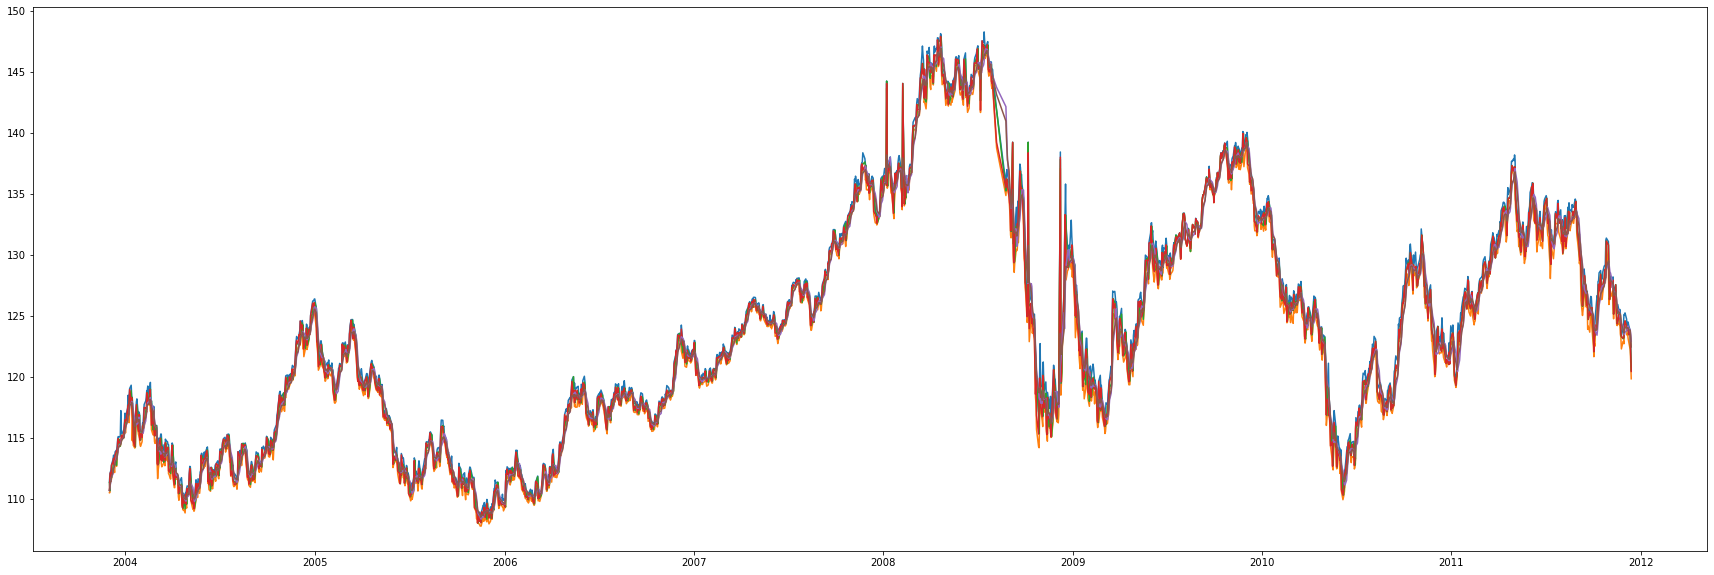

In [164]:
fig = plt.subplots(figsize=(30,10))
plt.plot(df_train)

In [165]:
# 分割後の詳細
print(f'単価抽出後のサマリ(df_train)\n{df_train.describe()}\n')
print(f'単価抽出後のサマリ(df_test)\n{df_test.describe()}\n')
# print(f'単価抽出後のサマリ(df_latest)\n{df_latest.describe()}\n')

単価抽出後のサマリ(df_train)
              High          Low         Open        Close        SMA01  \
count  2074.000000  2074.000000  2074.000000  2074.000000  2074.000000   
mean    124.078238   122.976785   123.526205   123.529490   123.515970   
std       9.210193     9.155624     9.188003     9.184970     9.141672   
min     108.520946   107.748581   107.993884   107.998923   108.316820   
25%     117.002707   115.876669   116.408944   116.427990   116.564712   
50%     123.242134   121.954434   122.590435   122.573382   122.595971   
75%     130.814157   129.426294   130.201913   130.179930   130.032894   
max     148.260942   146.834717   147.832063   147.888796   147.025652   

             EMA01  
count  2074.000000  
mean    123.515317  
std       9.124043  
min     108.479788  
25%     116.597826  
50%     122.608192  
75%     129.999944  
max     146.934929  

単価抽出後のサマリ(df_test)
              High          Low         Open        Close        SMA01  \
count  1246.000000  1246.00000

In [166]:
df_train.head()

,High,Low,Open,Close,SMA01,EMA01
Date,,,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377,110.676377,110.676377
2003-12-02,112.008532,110.500532,110.639316,111.823016,110.946101,111.003988
2003-12-03,112.202814,111.712284,111.832477,112.137524,111.215825,111.327856
2003-12-04,112.332259,111.406851,112.110343,111.748717,111.485549,111.448102
2003-12-05,112.766375,111.609834,111.721723,112.729259,111.755273,111.814147


In [167]:
# LSTMへの入力用に処理の関数

def data_maker(data):
  data_lstm_in=[]
  if len(data)==window_len:
    temp = data[:window_len].copy()
    temp = temp / temp.iloc[0] - 1
    data_lstm_in.append(temp)
  for i in range(len(data) - window_len): #今回のLSTMで生成する時系列データ数(train総数-10個のモデル)
      temp = data[i:(i + window_len)].copy() #windowの単位で行を取得。参照渡しでなく値渡し。
      temp = temp / temp.iloc[0] - 1
      data_lstm_in.append(temp)
  return data_lstm_in

In [168]:
#関数の実行(Trainデータ)
train_lstm_in = data_maker(df_train)

In [169]:
# 配列抜粋
print(f'train_lstm_in_配列数 : {len(train_lstm_in)}\n')
print(f'train_lstm_in[0]\n{train_lstm_in[0]}\n')
print(f'train_lstm_in[1]\n{train_lstm_in[1]}\n')
print(f'train_lstm_in[-1]\n{train_lstm_in[-1]}\n')

train_lstm_in_配列数 : 2068

train_lstm_in[0]
                High       Low      Open     Close     SMA01     EMA01
Date                                                                  
2003-12-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2003-12-02  0.005728  0.000167 -0.006064  0.010360  0.002437  0.002960
2003-12-03  0.007472  0.011135  0.004655  0.013202  0.004874  0.005886
2003-12-04  0.008634  0.008370  0.007151  0.009689  0.007311  0.006973
2003-12-05  0.012532  0.010208  0.003660  0.018549  0.009748  0.010280
2003-12-08  0.016610  0.017587  0.011134  0.021312  0.012185  0.013432

train_lstm_in[1]
                High       Low      Open     Close     SMA01     EMA01
Date                                                                  
2003-12-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2003-12-03  0.001735  0.010966  0.010784  0.002813  0.002431  0.002918
2003-12-04  0.002890  0.008202  0.013296 -0.000664  0.004862  0.004001
2003-12-05  0.00

In [170]:
lstm_train_out = (df_train['Open'][window_len:].values / df_train['Open'][:-window_len].values)-1

In [171]:
lstm_train_out

array([ 0.01554517,  0.02408164,  0.00835086, ..., -0.00716682,
       -0.01876104, -0.02665515])

In [172]:
#関数の実行(Testデータ)
test_lstm_in = data_maker(df_test)

In [173]:
# 配列抜粋(Testデータ)
print(f'test_lstm_in_配列数 : {len(test_lstm_in)}\n')
print(f'test_lstm_in[0]\n{test_lstm_in[0]}\n')
print(f'test_lstm_in[1]\n{test_lstm_in[1]}\n')
print(f'test_lstm_in[-1]\n{test_lstm_in[-1]}\n')

test_lstm_in_配列数 : 1240

test_lstm_in[0]
                High       Low      Open     Close     SMA01     EMA01
Date                                                                  
2011-12-15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2011-12-16  0.002682  0.003395  0.003284  0.003205  0.000673  0.000916
2011-12-19 -0.000613  0.001701  0.003741  0.003768  0.001346  0.001731
2011-12-20  0.006356  0.002625  0.001587  0.001522  0.002019  0.001671
2011-12-21  0.011123  0.005055  0.007748  0.007696  0.002693  0.003392
2011-12-22  0.005366  0.004675  0.003898  0.004003  0.003366  0.003567

test_lstm_in[1]
                High       Low      Open     Close     SMA01     EMA01
Date                                                                  
2011-12-16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2011-12-19 -0.003286 -0.001688  0.000456  0.000561  0.000673  0.000814
2011-12-20  0.003664 -0.000767 -0.001691 -0.001678  0.001345  0.000755
2011-12-21  0.00841

In [174]:
lstm_test_out = (df_test['Open'][window_len:].values / df_test['Open'][:-window_len].values)-1

In [175]:
lstm_test_out

array([-0.00474374, -0.00597099, -0.00581912, ..., -0.00734906,
        0.0050652 ,  0.00605043])

In [176]:
# #関数の実行(Latestデータ)
# latest_lstm_in = data_maker(df_latest)

In [177]:
# # 配列抜粋
# print(f'latest_lstm_in_配列数 : {len(latest_lstm_in)}\n')
# print(f'latest_lstm_in\n{latest_lstm_in[0]}\n')
# #print(f'latest_lstm_in\n{latest_lstm_in[1]}\n')
# # print(f'latest_lstm_in\n{latest_lstm_in[-1]}\n')

## Numpy配列への変換

In [178]:
# PandasのデータフレームからNumpy配列へ変換。リスト内包表記という記法がここでは使われている。
train_lstm_in = [np.array(train_lstm_input) for train_lstm_input in train_lstm_in]
train_lstm_in = np.array(train_lstm_in)

test_lstm_in = [np.array(test_lstm_input) for test_lstm_input in test_lstm_in]
test_lstm_in = np.array(test_lstm_in)

In [179]:
# # 11/6 latestデータのnumpyへの置き換え
# latest_lstm_in = [np.array(test_lstm_input) for test_lstm_input in latest_lstm_in]
# latest_lstm_in = np.array(latest_lstm_in)

In [180]:
print(f'train_lstm_in.shape[0] : {train_lstm_in.shape[0]}')
print(f'train_lstm_in.shape[1] : {train_lstm_in.shape[1]}')
print(f'train_lstm_in.shape[2] : {train_lstm_in.shape[2]}')

train_lstm_in.shape[0] : 2068
train_lstm_in.shape[1] : 6
train_lstm_in.shape[2] : 6


In [181]:
train_lstm_in

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.00572766,  0.00016718, -0.00606419,  0.01036029,
          0.00243705,  0.00296008],
        [ 0.00747212,  0.01113504,  0.00465466,  0.01320198,
          0.0048741 ,  0.00588634],
        [ 0.00863441,  0.0083705 ,  0.00715088,  0.00968897,
          0.00731115,  0.0069728 ],
        [ 0.01253235,  0.01020774,  0.00365969,  0.01854851,
          0.0097482 ,  0.01028015],
        [ 0.0166098 ,  0.01758695,  0.01113381,  0.02131179,
          0.01218525,  0.01343204]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.00173453,  0.01096603,  0.01078424,  0.00281255,
          0.00243113,  0.00291762],
        [ 0.0028902 ,  0.00820195,  0.0132957 , -0.00066443,
          0.00486225,  0.00400088],
        [ 0.00676594,  0.01003888,  0.00978321,  0.00810426,
          0.00729338,  0.00729846],
        [ 0.01082017,  0.017

## モデルの定義

In [182]:
# モデルの定義
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [183]:
# LSTMのモデルを設定
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
 
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2]))) #バッチ数、時系列データ数、特徴量数
    model.add(Dropout(dropout)) 
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
 
    model.compile(loss=loss, optimizer=optimizer)
    return model

## データの学習と予測

In [184]:
np.random.seed(202)
 
# 初期モデルの構築
yen_model = build_model(train_lstm_in, output_size=1, neurons = 20)

# データを流してフィッティングさせる
yen_history = yen_model.fit(train_lstm_in, lstm_train_out, 
                            epochs=20, batch_size=1, verbose=2, shuffle=False)
# 11/5 epochs=50からepochs=10に変更
# 11/5 shuffle=TrueからFalseに変更

Epoch 1/20
2068/2068 - 4s - loss: 0.0068
Epoch 2/20
2068/2068 - 3s - loss: 0.0055
Epoch 3/20
2068/2068 - 3s - loss: 0.0049
Epoch 4/20
2068/2068 - 3s - loss: 0.0046
Epoch 5/20
2068/2068 - 3s - loss: 0.0044
Epoch 6/20
2068/2068 - 3s - loss: 0.0042
Epoch 7/20
2068/2068 - 3s - loss: 0.0042
Epoch 8/20
2068/2068 - 3s - loss: 0.0040
Epoch 9/20
2068/2068 - 3s - loss: 0.0040
Epoch 10/20
2068/2068 - 3s - loss: 0.0039
Epoch 11/20
2068/2068 - 3s - loss: 0.0038
Epoch 12/20
2068/2068 - 3s - loss: 0.0038
Epoch 13/20
2068/2068 - 3s - loss: 0.0037
Epoch 14/20
2068/2068 - 3s - loss: 0.0038
Epoch 15/20
2068/2068 - 3s - loss: 0.0037
Epoch 16/20
2068/2068 - 3s - loss: 0.0035
Epoch 17/20
2068/2068 - 3s - loss: 0.0037
Epoch 18/20
2068/2068 - 3s - loss: 0.0038
Epoch 19/20
2068/2068 - 3s - loss: 0.0037
Epoch 20/20
2068/2068 - 3s - loss: 0.0037


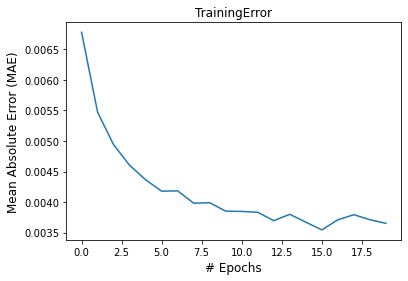

In [185]:
# MAEをプロットしてみよう
fig, ax1 = plt.subplots(1,1)
 
ax1.plot(yen_history.epoch, yen_history.history['loss'])
ax1.set_title('TrainingError')
 
if yen_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

In [186]:
#作成したモデルを使用し予測。
train_pred = yen_model.predict(train_lstm_in)
# test_pred = yen_model.predict(X_test)

In [187]:
train_pred

array([[ 0.01426768],
       [ 0.01872927],
       [ 0.00583021],
       ...,
       [-0.00685645],
       [-0.00579564],
       [-0.01519665]], dtype=float32)

In [188]:
np.transpose(train_pred)

array([[ 0.01426768,  0.01872927,  0.00583021, ..., -0.00685645,
        -0.00579564, -0.01519665]], dtype=float32)

In [189]:
len(train_pred)

2068

In [190]:
lstm_train_out

array([ 0.01554517,  0.02408164,  0.00835086, ..., -0.00716682,
       -0.01876104, -0.02665515])

In [191]:
len(lstm_train_out)

2068

In [192]:
# yen_model.score(train_pred, lstm_train_out) 

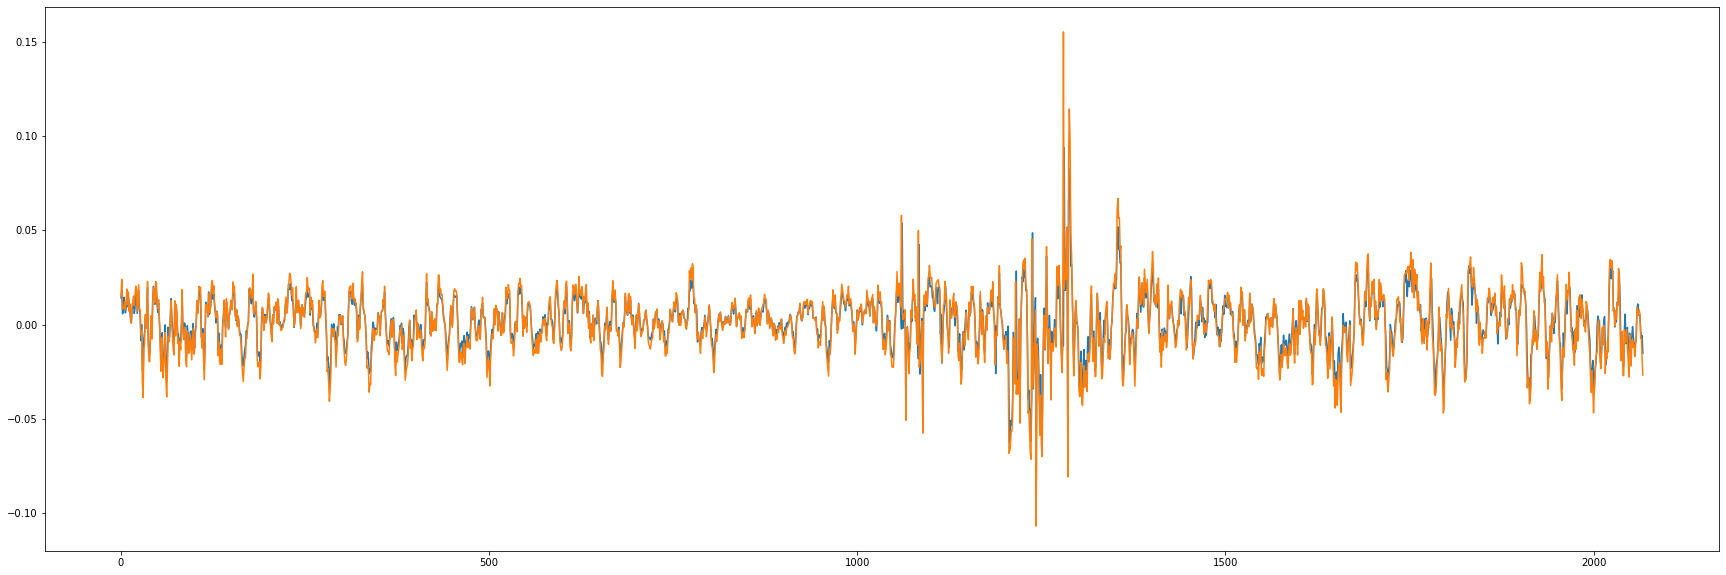

In [193]:
fig,ax = plt.subplots(figsize=(30,10))
# plt.plot(train_pred)

ax.plot(train_pred)
ax.plot(lstm_train_out)
plt.show()

In [194]:
# 配列には変化量が入っているので１００倍
np.transpose(train_pred+1)

array([[1.0142677 , 1.0187293 , 1.0058302 , ..., 0.99314356, 0.99420434,
        0.9848033 ]], dtype=float32)

In [195]:
#予測データ(変化量)を単価に直したもの
Pred_Train_Price_Array=(np.transpose(train_pred+1)* df_train['Open'].values[:-window_len])[0]
(np.transpose(train_pred+1)* df_train['Open'].values[:-window_len])[0]

array([112.90254491, 112.711516  , 112.48447936, ..., 123.71995528,
       123.39178906, 121.92727781])

In [196]:
#正解データ(変化量)を単価に直したもの
Actual_Train_Price_Array=(1+lstm_train_out)* df_train['Open'].values[:-window_len]
(1+lstm_train_out)* df_train['Open'].values[:-window_len]

array([113.04474801, 113.30369174, 112.76637495, ..., 123.68128955,
       121.78264081, 120.50861955])

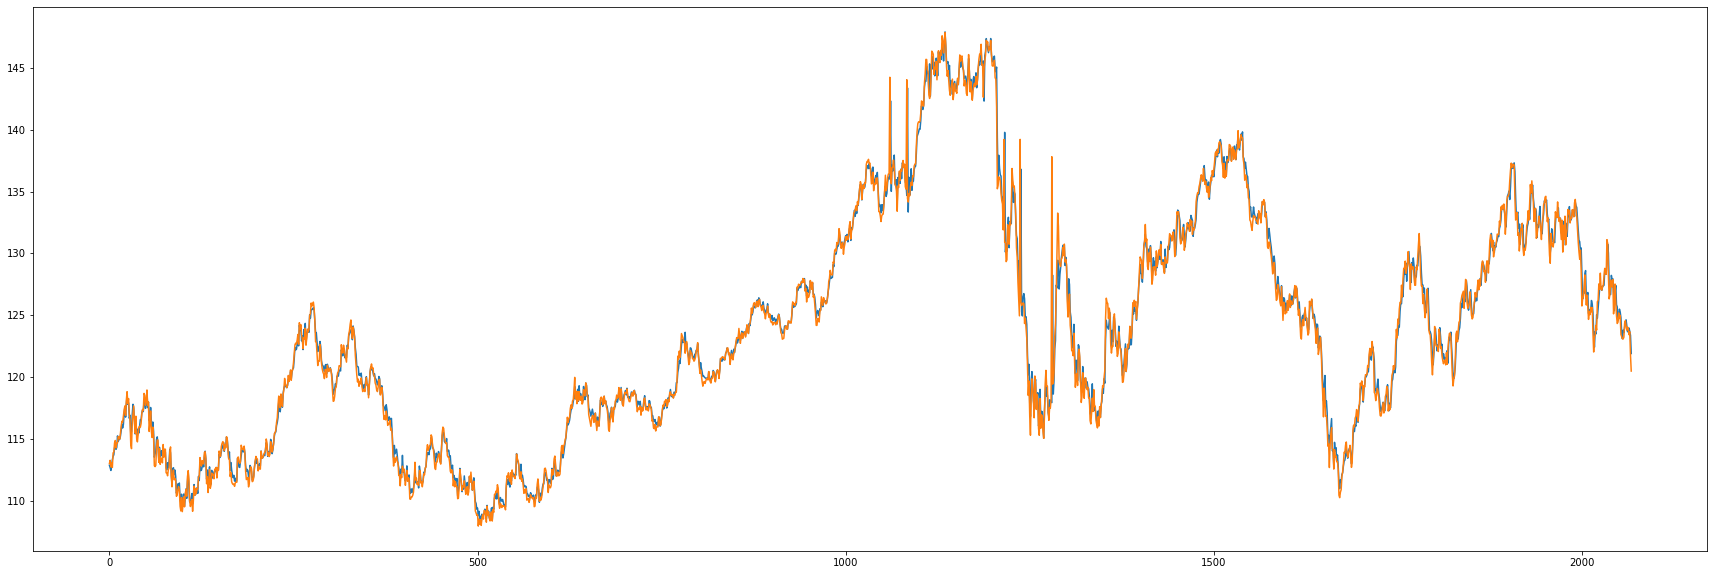

In [197]:
fig,ax = plt.subplots(figsize=(30,10))

# 予測データと正解データの併記
ax.plot(Pred_Train_Price_Array)
ax.plot(Actual_Train_Price_Array)
plt.show()

In [198]:
# #元のdf_trainデータ
# fig,ax = plt.subplots(figsize=(30,10))
# # plt.plot(train_pred)

# # ax.plot(np.transpose(train_pred+1)* df_train['Open'].values[:-window_len])
# ax.plot(df_train['Open'])
# # ax.set_xlim(datetime.datetime(2003,12,1), datetime.datetime(2011,12,14)) # 範囲指定
# plt.show()

## テストデータへの転用

In [199]:
#作成したモデルを使用し予測。
test_pred = yen_model.predict(test_lstm_in)

In [200]:
test_pred

array([[ 0.00475777],
       [-0.00921877],
       [-0.00434682],
       ...,
       [-0.00563217],
       [ 0.00044205],
       [ 0.00523272]], dtype=float32)

In [201]:
len(test_pred)

1240

In [202]:
np.transpose(test_pred)

array([[ 0.00475777, -0.00921877, -0.00434682, ..., -0.00563217,
         0.00044205,  0.00523272]], dtype=float32)

In [203]:
len(lstm_test_out)

1240

In [204]:
# 予測データ(変化量)を単価に直したもの
Pred_Price_Array=(np.transpose(test_pred+1)* df_test['Open'].values[:-window_len])[0]
(np.transpose(test_pred+1)* df_test['Open'].values[:-window_len])[0]

array([120.70455375, 119.41634067, 120.05829087, ..., 102.86410933,
       102.95361946, 103.55721945])

In [205]:
typeInfo(Pred_Price_Array)

Pred_Price_Array は ndarray型
Pred_Price_Array の行数, 列数・・・(1240,)



In [206]:
# 正解データ(変化量)を単価に直したもの
Actual_Price_Array=(1+lstm_test_out)* df_test['Open'].values[:-window_len]
(1+lstm_test_out)* df_test['Open'].values[:-window_len]

array([119.56311047, 119.80778545, 119.88076121, ..., 102.68650234,
       103.42938185, 103.64146143])

In [207]:
typeInfo(Actual_Price_Array)

Actual_Price_Array は ndarray型
Actual_Price_Array の行数, 列数・・・(1240,)



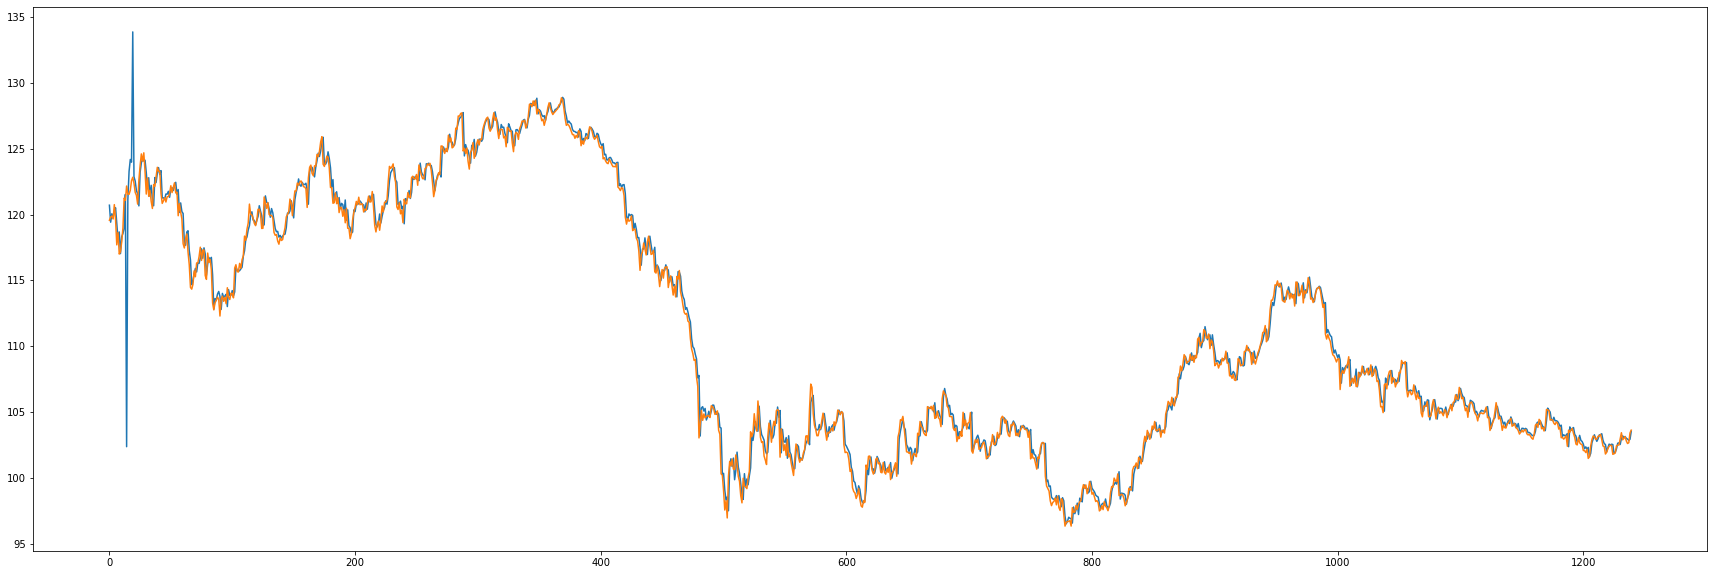

In [208]:
fig,ax = plt.subplots(figsize=(30,10))
# fig,ax = plt.subplots()

# 正解データと予測データの併記
ax.plot(Pred_Price_Array)
ax.plot(Actual_Price_Array)
plt.show()

In [209]:
# Actual_Price_Array[::12]

In [210]:
len(Pred_Price_Array)

1240

In [211]:
Pred_Price_Array_7=Pred_Price_Array[::6]
Pred_Price_Array_7

array([120.70455375, 119.31332606, 118.94292118, 123.96917433,
       120.65318146, 123.19351061, 120.66059653, 123.32896297,
       121.75766114, 122.44312799, 120.07784029, 116.55023335,
       116.34053086, 117.01275596, 115.43298065, 113.78144532,
       113.01660276, 114.12720523, 116.00237604, 119.15442442,
       119.55546994, 119.22217339, 120.4508382 , 118.28580284,
       119.00337418, 119.74247302, 122.14280958, 120.78201113,
       123.59976404, 125.86000519, 123.54301456, 120.8392499 ,
       121.10204927, 118.66964493, 121.03045954, 120.40228618,
       120.31102988, 119.85990633, 122.5564529 , 122.45785507,
       119.29613111, 121.66795216, 122.56358205, 123.84667566,
       122.53522793, 122.84468974, 125.1211839 , 125.75708634,
       127.73049037, 123.89243346, 125.28659248, 126.9644914 ,
       126.68773399, 126.0833702 , 125.44500651, 125.21717806,
       126.81419804, 127.52640811, 128.81989556, 127.49899527,
       127.95970088, 128.15204623, 127.47412432, 126.31

In [212]:
len(Pred_Price_Array_7)

207

In [213]:
df_test_Close_array=df_test['Close'].values
df_test_Close_array

array([120.13923079, 120.52431077, 120.59187233, ..., 102.68535554,
       103.43631774, 103.6212492 ])

In [214]:
df_test_Close_array6=df_test_Close_array[5::6]
df_test_Close_array6

array([120.62017828, 119.61567551, 119.0108633 , 121.82273448,
       120.78713596, 123.21832687, 120.4583922 , 123.26759487,
       121.35922045, 122.40306705, 119.66364235, 116.19142771,
       116.30831242, 117.29647338, 115.77551663, 113.56660515,
       113.23295444, 113.6782521 , 115.91478586, 119.35484618,
       119.1549623 , 118.94046783, 119.92739379, 118.02985877,
       119.00167793, 119.91185695, 122.44843155, 120.55258363,
       123.69617581, 125.9017241 , 123.51448625, 120.80449224,
       120.36435515, 118.54718387, 121.31147414, 120.3173697 ,
       120.56829691, 119.55693543, 122.52141833, 122.4289912 ,
       119.39642847, 121.27329916, 122.2106263 , 123.52438837,
       122.43547499, 123.01513493, 124.74713475, 125.39992481,
       127.69893676, 123.46831679, 125.35913646, 126.78527325,
       126.52513862, 125.76307237, 125.13020784, 124.76564884,
       126.72448218, 127.43679523, 128.69565457, 127.20721602,
       128.07731241, 128.02591622, 127.28598088, 126.06

In [215]:
len(df_test_Close_array6)

207

In [216]:
Dif_Array=Pred_Price_Array_7-df_test_Close_array6
Dif_Array

array([ 8.43754706e-02, -3.02349450e-01, -6.79421215e-02,  2.14643985e+00,
       -1.33954495e-01, -2.48162550e-02,  2.02204327e-01,  6.13680974e-02,
        3.98440699e-01,  4.00609391e-02,  4.14197945e-01,  3.58805647e-01,
        3.22184423e-02, -2.83717424e-01, -3.42535975e-01,  2.14840167e-01,
       -2.16351683e-01,  4.48953129e-01,  8.75901782e-02, -2.00421757e-01,
        4.00507643e-01,  2.81705556e-01,  5.23444408e-01,  2.55944074e-01,
        1.69624495e-03, -1.69383924e-01, -3.05621970e-01,  2.29427491e-01,
       -9.64117718e-02, -4.17189085e-02,  2.85283032e-02,  3.47576643e-02,
        7.37694127e-01,  1.22461057e-01, -2.81014607e-01,  8.49164803e-02,
       -2.57267032e-01,  3.02970902e-01,  3.50345650e-02,  2.88638666e-02,
       -1.00297354e-01,  3.94653005e-01,  3.52955741e-01,  3.22287287e-01,
        9.97529395e-02, -1.70445189e-01,  3.74049152e-01,  3.57161530e-01,
        3.15536120e-02,  4.24116668e-01, -7.25439797e-02,  1.79218151e-01,
        1.62595375e-01,  

In [217]:
Df_Dif_Array = pd.Series(Dif_Array)
Df_Dif_Array

0      0.084375
1     -0.302349
2     -0.067942
3      2.146440
4     -0.133954
         ...   
202    0.007439
203    0.149304
204    0.070705
205    0.037769
206    0.142365
Length: 207, dtype: float64

In [218]:
def p_judge(x):
    if x < 0:
        return 0
    else:
        return 1

In [219]:
Df_sub=Df_Dif_Array.apply(p_judge)
Df_sub

0      1
1      0
2      0
3      1
4      0
      ..
202    1
203    1
204    1
205    1
206    1
Length: 207, dtype: int64

In [220]:
Df_sub.describe()

count    207.000000
mean       0.714976
std        0.452520
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [221]:
df_submit[1]=Df_sub
df_submit

,Date,1
0,2011-12-22,1
1,2012-01-05,0
2,2012-01-19,0
3,2012-02-02,1
4,2012-02-16,0
...,...,...
202,2019-10-23,1
203,2019-11-07,1
204,2019-11-21,1
205,2019-12-05,1


In [222]:
# 指定の様式（インデックスはDate、カラム名は「y」のみ）をお守りください。
df_submit = df_submit.set_index("Date") #indexにDateを指定する。
df_submit = df_submit.rename(columns={1: 'y'}) #カラム名「1」を「y」に変更する。
df_submit.to_csv('y_submit.csv') #投稿するファイルを書き出す。
df_submit #投稿する中身を確認する。

,y
Date,
2011-12-22,1
2012-01-05,0
2012-01-19,0
2012-02-02,1
2012-02-16,0
...,...
2019-10-23,1
2019-11-07,1
2019-11-21,1
